In [6]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend, CudaBackend
from qilisdk.functionals import TimeEvolution

## Generate Hamiltonian

In [7]:
nqubits = 4
connectivity = "nearest-neighbours"

# target_weights = [0.5, 0.8, 0.1, 0.4, 0.5, 0.1, 0.6, 0.8]
# H_target = hamiltonian.create_hamiltonian_from_weights(nqubits, target_weights, connectivity)
min_w = -1
max_w = 1
H_target, target_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, connectivity, backend='qilisdk')


print("Target Hamilonian: \n", H_target.H, "\n")
print("Target weights:", target_weights)

Target Hamilonian: 
 0.20640276350917408 X(0) + 0.7708428571876447 Z(0) - 0.4875590752201002 X(1) + 0.8973640317099725 Z(1) + 0.717892661520636 X(2) + 0.8101852026221972 Z(2) + 0.036275825331738565 X(3) + 0.19423962907991243 Z(3) + 0.19566946293151544 Z(0) Z(1) + 0.9240655139823624 Z(1) Z(2) + 0.20384777054835213 Z(2) Z(3) 

Target weights: [ 0.20640276 -0.48755908  0.71789266  0.03627583  0.77084286  0.89736403
  0.8101852   0.19423963  0.19566946  0.92406551  0.20384777]


## Create target trajectory

In [8]:
ti = 0
times = np.linspace(0.01, 3, 20)

initial_zero_state = tensor_prod([ket(0).unit() for _ in range(nqubits)]).unit()
initial_minus_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()

Hx = sum(X(i) for i in range(nqubits)) #Driver

target_states = []
target_x, target_y, target_z = [], [], []
T_final = times[-1]
for T in times:
    dt = T/100
    steps = np.linspace(0, T, int(T / dt))
    sim = VQE.simulate_annealing(T, dt, T_final, steps, Hx, H_target.H, initial_zero_state)
    #save expectation values
    target_x.append(sim.final_expected_values[0])
    target_y.append(sim.final_expected_values[1])
    target_z.append(sim.final_expected_values[2])

    #save final state as qutip object
    target_state_data = sim.final_state.data
    target_state_array = target_state_data.toarray()
    target_qutip_state = qt.Qobj(target_state_array, dims=[[2]*nqubits, [1]])

    target_states.append(target_qutip_state)

In [ ]:
# Define Hamiltonians
alpha = 1.

if connectivity == "all-to-all":
    initial_weights = np.random.uniform(min_w, max_w, size=(2*nqubits + int(nqubits*(nqubits-1)/2)))
elif connectivity == "nearest-neighbours":
    initial_weights = np.random.uniform(min_w, max_w, size=(3*nqubits -1))

options={
    'maxiter': 2000,           # Increase iterations
    'ftol': 1e-10,            # Function tolerance
    'gtol': 1e-8,             # Gradient tolerance  
    'maxfun': 10000,          # Max function evaluations
    'disp': True              # Print convergence messages
    }

alphas = np.linspace(1, 0, 1)
losses = []
leraned_parameters = []
observables = [target_x, target_y, target_z]

print("target_weights:", target_weights)
print("initial_weights:", initial_weights)
for alpha in alphas:
    print("Alpha = ", alpha)
    final_result = VQE.learn_hamiltonian(nqubits, initial_weights, Hx, initial_zero_state, target_states, times, connectivity, alpha, observables = observables, optimizer_options = options, mode = "segmented")
    print("Loss = ", final_result.fun)
    print("Params:", final_result.x)
    losses.append(final_result.fun)
    leraned_parameters.append(final_result.x)

target_weights: [ 0.20640276 -0.48755908  0.71789266  0.03627583  0.77084286  0.89736403
  0.8101852   0.19423963  0.19566946  0.92406551  0.20384777]
initial_weights: [ 0.38115443  0.5858293   0.11601835 -0.32967264 -0.4128715   0.69641167
 -0.82712028  0.39495877 -0.73468006 -0.26860068 -0.81930748]
Alpha =  1.0


8.228630582474139e-07


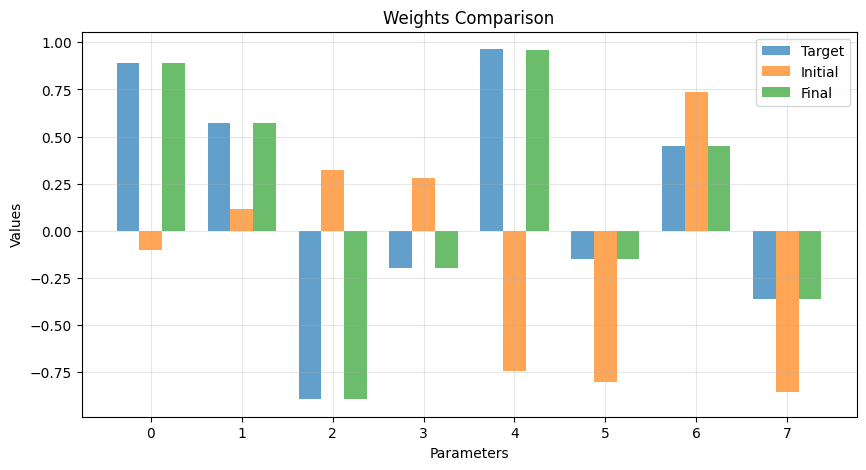

In [ ]:
print(final_result.fun)
final_weights = final_result.x
plots.plot_weights(target_weights, initial_weights, final_weights)